## Introduction to Atmospheric Radar Course - Practical 4

<img src="NCAS_national_centre_logo_transparent.png" alt="NCAS" style="width: 200px; horizontal-align:left"/>


## Developing radar processing chains
### Part 4 - Application of corrections through to QPE

#### Overview
This notebook introduces methods for correcting weather radar data through to radar quantitative precipitation estimates (QPE). We'll apply what we've learned in the previous 3 practical exercises to build a short processing chain and then calculate QPEs using 2 methods.

The final processing chain will:

1. Remove non-meteorological echoes (See practical 4 part 1 and part 2)
2. Process Kdp from differential phase shift (See practical 4 part 3)
3. Correct reflectivity for attenuation (See practical 4 part 3)
4. Calculate QPE in rain using R(Kdp) and R(Z)
5. Create a hybrid R relation within rain while also using a different R(Z) relation above the melting layer


We'll start as usual by importing the python modules we need for this notebook

In [1]:
import pyart
import pyart.graph.cm_colorblind as pycm
import matplotlib.pyplot as plt
import scipy.ndimage as sciim
import numpy as np


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Then we can load an example file containing a mixture of precipitation and non-meteorological echoes, as shown in the lecture and set up a ```RadarMapDisplay``` object for that file, allowing us to plot the coastline which will help give an idea of the source of some of the clutter. This is the same example file as used in part 3.

In [2]:
radar_file = '/gws/nopw/j04/ncas_radar_vol2/data/ncas-mobile-x-band-radar-1/raine/cfradial/calib_v1/sur/20200723/ncas-mobile-x-band-radar-1_sandwith_20200723-094532_SUR_v1.nc'

radar = pyart.io.read(radar_file)
raddisp = pyart.graph.RadarMapDisplay(radar)

We'll plot up the reflectivity again to remind us of the case study. We'll also plot up 3 higher elevation angles to see how things change with altitude.

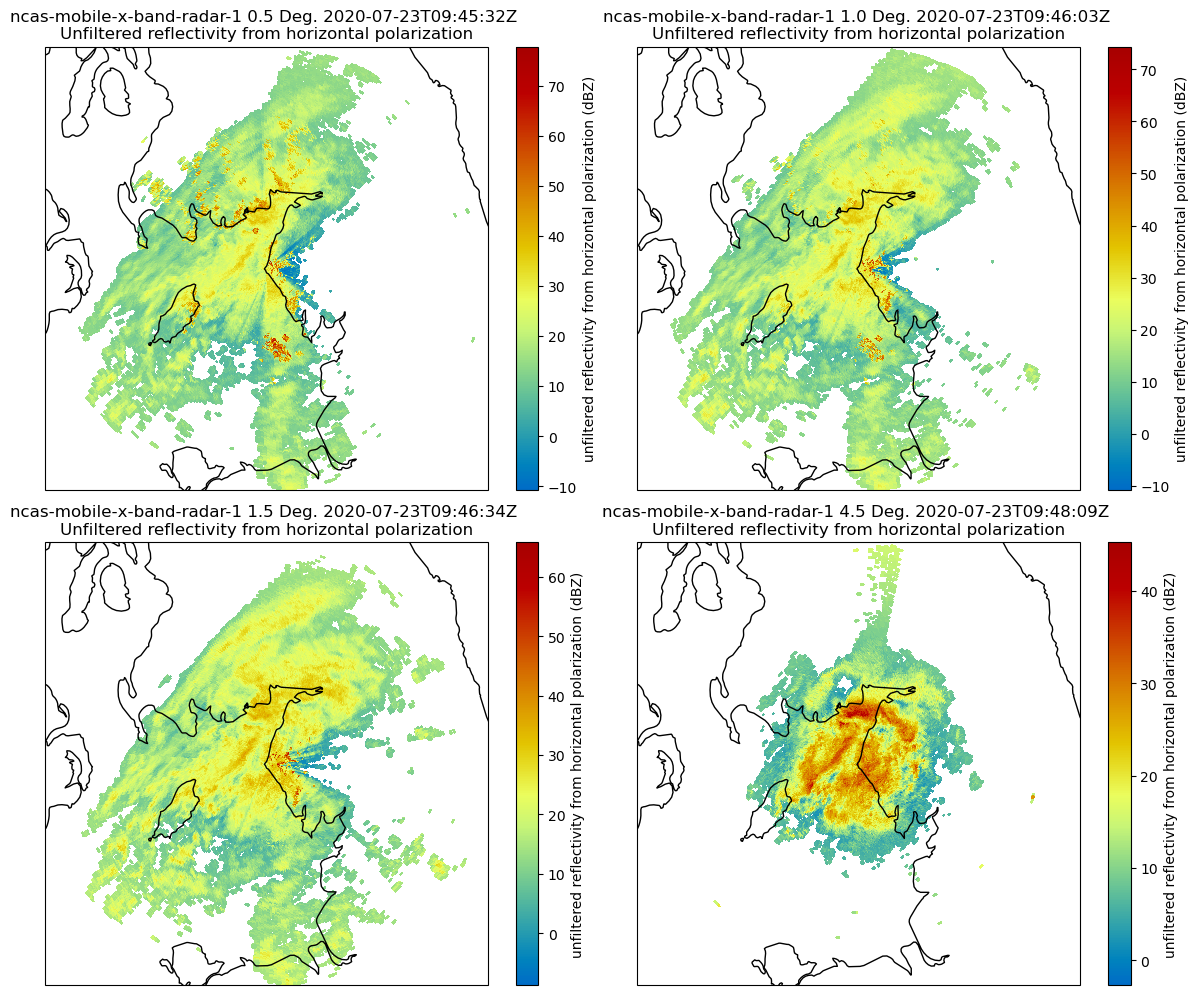

In [3]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("dBuZ", 0,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("dBuZ", 1,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("dBuZ", 2,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                 ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("dBuZ", 5,
                 cmap=pycm.HomeyerRainbow,
                     embellish=False,
                 ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

To build up our processing chain we'll use the gatefilters from part 2 along with the Maesaka method of $K_{DP}$ estimation plus linear attenuation correction from part 3. We'll replot the above using the corrected reflectivity to sense check our processing chain so far.

In [4]:
## Unwrap differential phase:

radar.fields['uPhiDPu']['data'][:] = np.ma.masked_array(data=np.where(radar.fields['uPhiDPu']['data']>180,
                                                                  radar.fields['uPhiDPu']['data']-360,
                                                                  radar.fields['uPhiDPu']['data']),
                                                    mask=radar.fields['uPhiDPu']['data'].mask)

## Build up the gatefilter
gatefilter = pyart.filters.moment_and_texture_based_gate_filter(radar,
                                                                 'ZDRu',
                                                                 'RhoHVu',
                                                                 'uPhiDPu',
                                                                 'dBuZ',
                                                                 min_rhv=0.85)
gatefilter.exclude_below('SQI',0.4)
gatefilter = pyart.correct.despeckle_field(radar,'dBuZ',gatefilter=gatefilter)

## Calculate KDP and PhiDP and add to file:
kdp_maesaka = pyart.retrieve.kdp_maesaka(radar,gatefilter=gatefilter,psidp_field='uPhiDPu')
radar.add_field('PhiDP_Maesaka', kdp_maesaka[1]) # Adding PhiDP for linear correction
system_phase = np.ma.median(radar.fields['PhiDP_Maesaka']['data'][:,:10])
radar.fields['PhiDP_Maesaka']['data'] = radar.fields['PhiDP_Maesaka']['data']-system_phase
radar.add_field('KDP_Maesaka', kdp_maesaka[0]) # Adding Kdp for precipitation estimation

linear_correction_results  = pyart.correct.calculate_attenuation_philinear(radar,
                                                                           gatefilter=gatefilter,
                                                                           phidp_field='PhiDP_Maesaka',
                                                                           refl_field='dBuZ',
                                                                           zdr_field='ZDR',
                                                                           fzl=2500,
                                                                           temp_ref='fixed_fzl')

radar.add_field('linear_PIA',linear_correction_results[1],replace_existing=True)
radar.add_field("corrected_reflectivity_Phase",
                linear_correction_results[2])
radar.add_field("corrected_ZDR_Phase",
                linear_correction_results[5])

/home/users/dufton/software/miniconda3/envs/RadarEnv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/users/dufton/software/miniconda3/envs/RadarEnv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


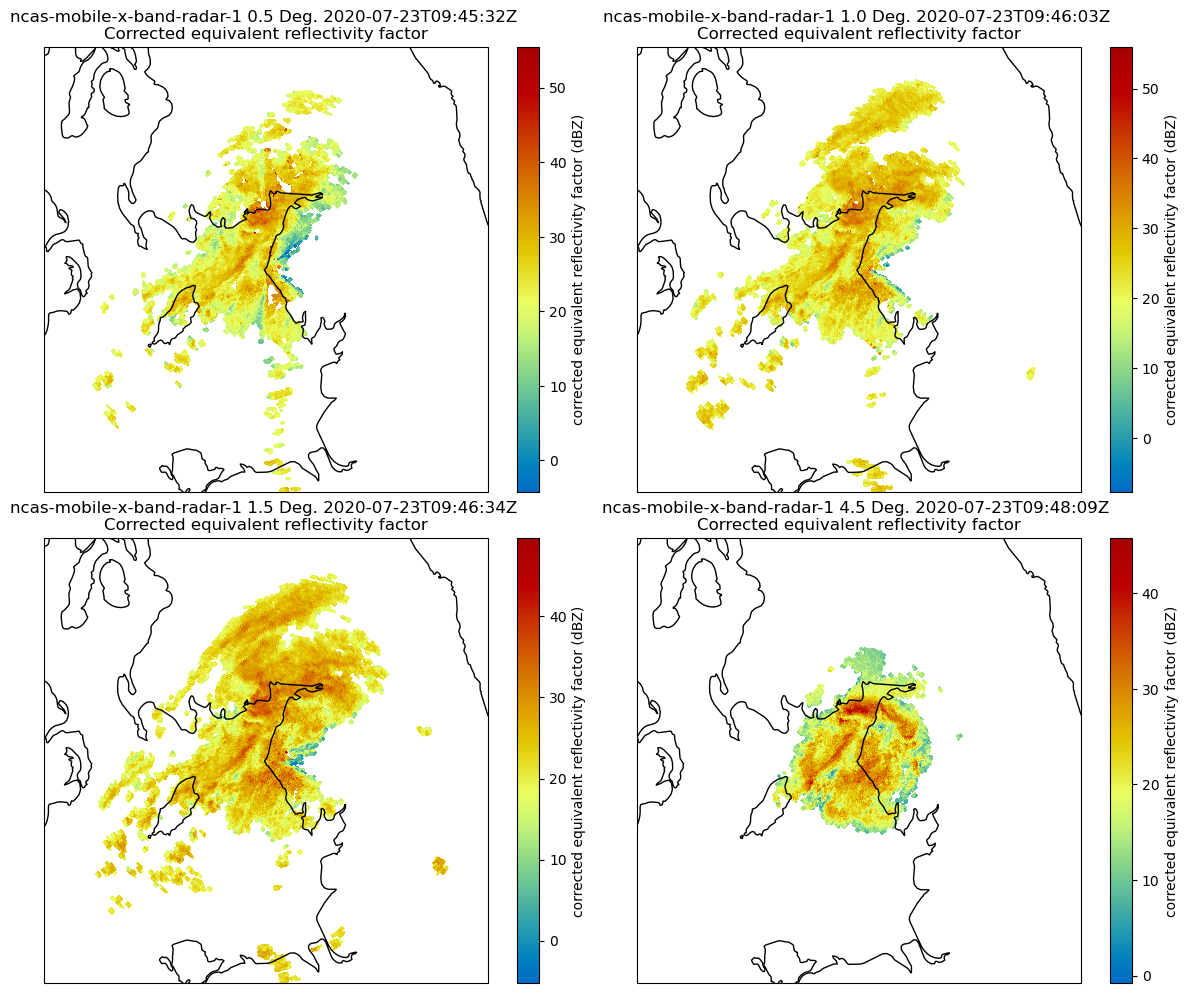

In [5]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("corrected_reflectivity_Phase", 0,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("corrected_reflectivity_Phase", 1,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("corrected_reflectivity_Phase", 2,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                 ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("corrected_reflectivity_Phase", 5,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                 ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

Both R(Z) and R($K_{DP}$) are relatively straighforward transformations of radar moments into rainrate using an equation of the form:

$R= aM^b$

Where M is the radar moment in question. As we noted in the lecture, there can be significant variation in the $a$ and $b$ parameters for reflectivity estimates depending on the atmospheric conditions. While there is also some variability for $K_{DP}$ it is significantly lower, which is one of its main advantages for rainfall estimation. A good overview of the variability is found in Chapter 10 of Ryzhkov and Zrnic (2019).

Although these equations are relatively easy to code with numpy for example (or even in pure python) we'll here use the retrieval functions found within Py-ART ([```pyart.retrieve.est_rain_rate_z```](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_z.html) and [```pyart.retrieve.est_rain_rate_kdp```](https://arm-doe.github.io/pyart/API/generated/pyart.retrieve.est_rain_rate_kdp.html))  for convenience. In both cases these functions contain default values for $a$ and $b$.

##### Activity
Before we run the code blocks, take a couple of minutes to look into the function documentation and consider whether the default values are likely to be acceptable for use with this data.

In [6]:
ZR_dict = pyart.retrieve.est_rain_rate_z(radar,refl_field='corrected_reflectivity_Phase')

In [7]:
KDPR_dict = pyart.retrieve.est_rain_rate_kdp(radar,kdp_field='KDP_Maesaka')

In [8]:
radar.add_field('Rainfall_Z',ZR_dict)
radar.add_field('Rainfall_KDP', KDPR_dict)

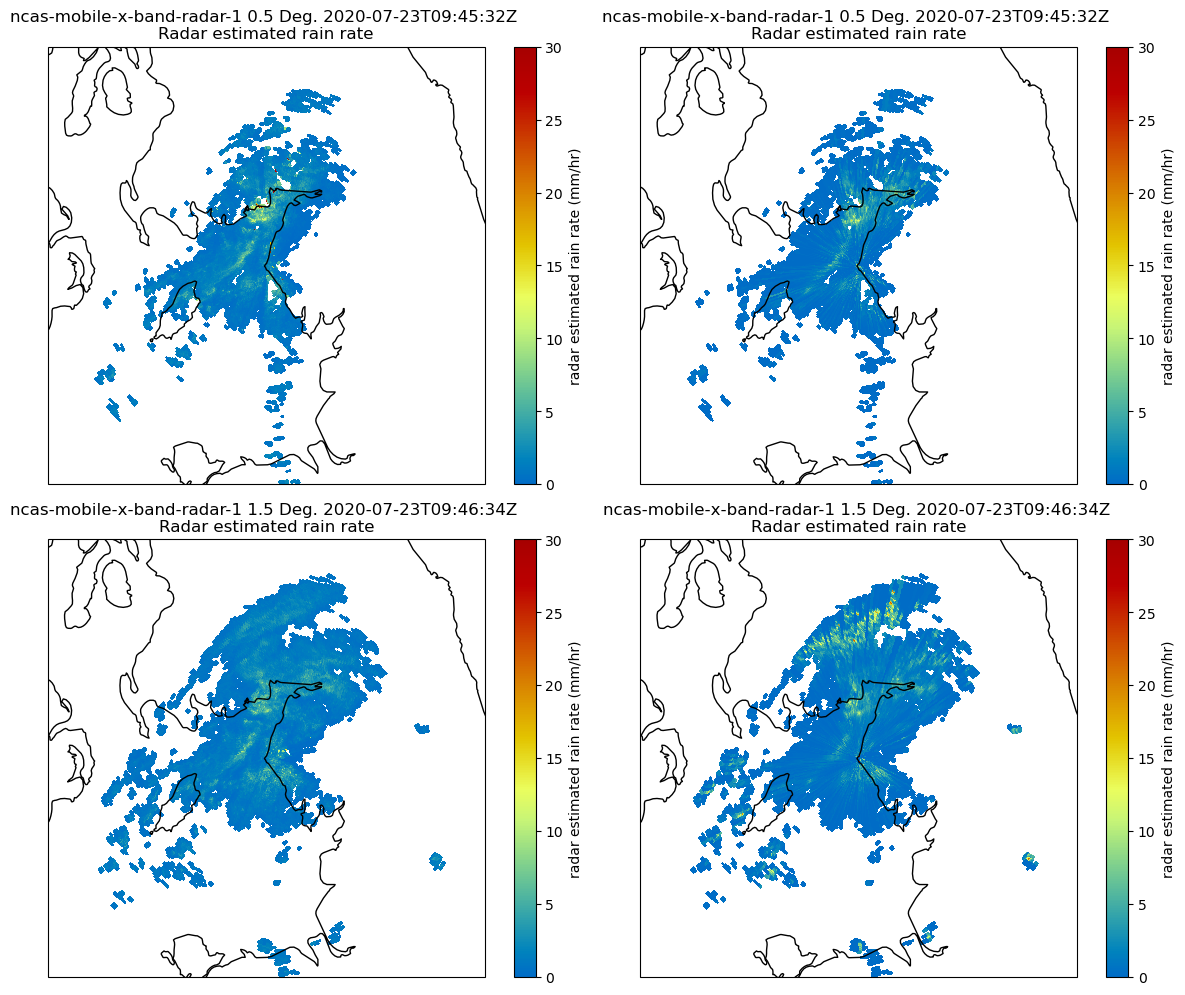

In [9]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("Rainfall_Z", 0,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("Rainfall_KDP", 0,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("Rainfall_Z", 2,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("Rainfall_KDP", 2,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

We can see from the plots that R(Z) and R($K_{DP}$) provide similar spatial patterns of rainfall at the lower elevation angle but when we step up to 1.5$^\circ$ there is more variation especially to the north.

The higher intensity rainfall rates to the north are due to an artefact in the $K_{DP}$ estimates resulting from backscatter differential phase ($\delta$) in the melting layer. We've also discussed in the lectures how the vertical profile of reflectivity changes above the melting layer and how QPE based on liquid precipitation are no longer valid as phase changes. We'll finish this practical by developing a multi-relation estimate of precipitation rate that incorporates the presence of the melting layer.

From vertically pointing radar data at this time the base of the melting layer occurs at 2500m and its approximately 600m deep, although the depth and height is likely to vary across the domain we'll use these values for this example. Many weather services instead use model data to estimate melting layer height variation across the domain during their processing.

To estimate QPE above the melting layer we'll use a S(Z) relation. Reading the literature we'll quickly see that these vary greatly but for this exercise we'll use $S = 400Z^{2}$.

Within the melting layer itself we can either mask the data completely or apply a reduction factor to R(Z).

Below the melting layer we'll use R($K_{DP}$) if it exceeds 10mm/hr (a common approach to the difficulty of estimating $K_{DP}$ in light rainfall) otherwise we will use R(Z).

In [10]:
# Start by generating S(Z)
ZS_dict = pyart.retrieve.est_rain_rate_z(radar,
                                         alpha=0.05,
                                         beta=0.5,
                                         refl_field='corrected_reflectivity_Phase')

In [11]:
## We'll start with S(Z) above the melting layer top

R_hybrid = np.where(radar.gate_altitude['data']>3100,
                    ZS_dict['data'],
                    np.nan)

## Then we'll add in R(Z) below the melting layer base

R_hybrid = np.where(radar.gate_altitude['data']<2500,
                    ZR_dict['data'],
                    R_hybrid)

## Then we'll replace R(Z) with R(KDP) if R(KDP)>10mm/hr below the melting layer

R_hybrid = np.where(np.logical_and(radar.gate_altitude['data']<2500,
                                   KDPR_dict['data']>10),
                    KDPR_dict['data'],
                    R_hybrid)

## Then mask R hybrid with the gatefilter

R_hybrid = np.ma.masked_where(gatefilter.gate_excluded,
                              R_hybrid)

## Finally add R hybrid to the radar object as a field like R(Z)

radar.add_field_like('Rainfall_Z', 'Rainfall_hybrid', data=R_hybrid)

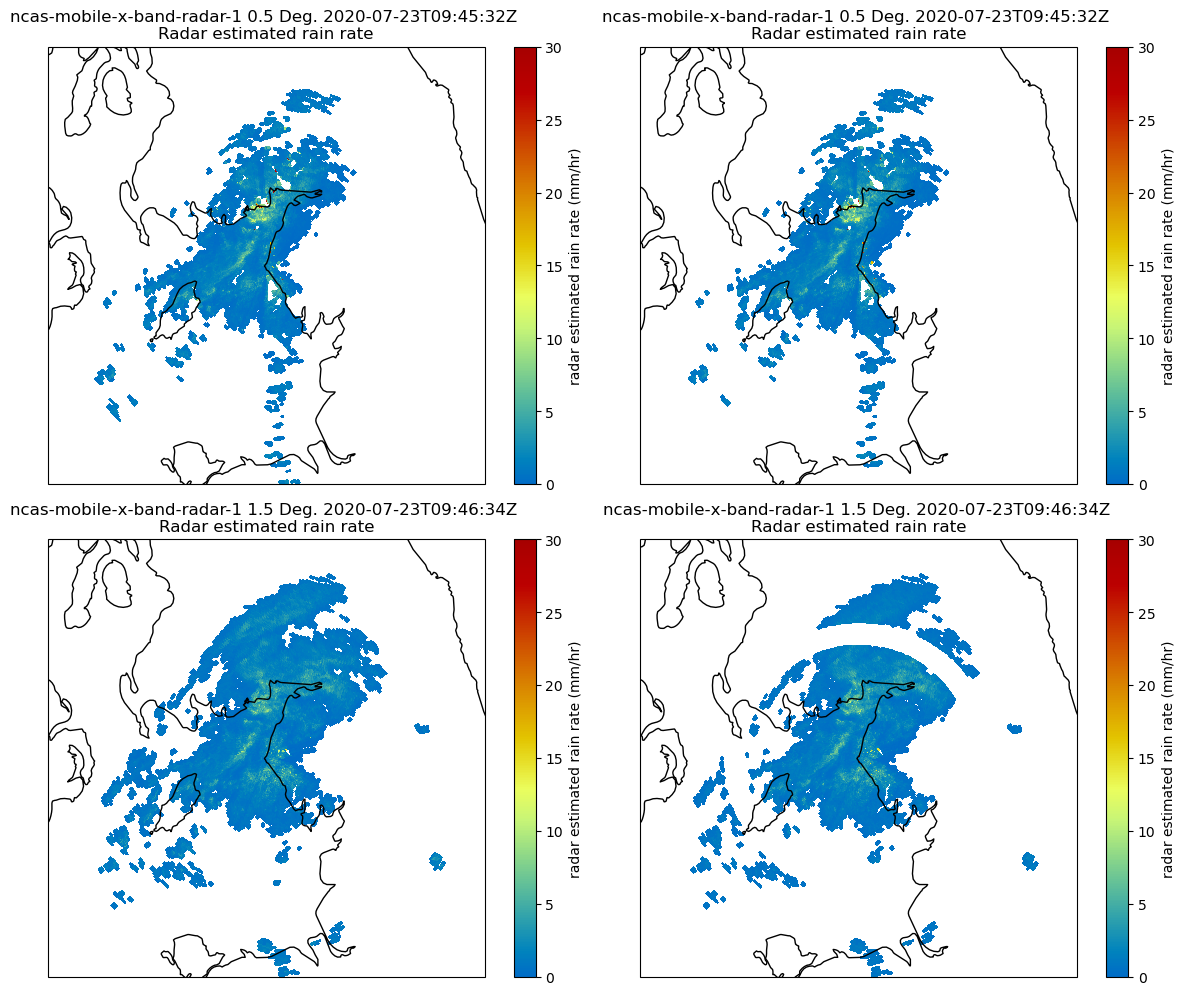

In [12]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("Rainfall_Z", 0,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("Rainfall_hybrid", 0,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("Rainfall_Z", 2,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("Rainfall_hybrid", 2,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

While the new hybrid QPE has removed the $K_{DP}$ artifact at 1.5$^{\circ}$ elevation the missing data gap could be filled if we make an assumption about QPE within the melting layer. Rather than attempt a full VPR correction in this tutorial we'll simply assume that within the melting layer R(Z) is an overestimate due to the reflectivity peak caused by melting hydrometeors and scale them accordingly. On Friday we'll instead consider surface rainfall estimation and the combination of data from multiple elevation angles. 

In [13]:
## We'll create a new version with 0.6*R(Z) in the melting layer as opposed to a data gap.

R_hybrid_2 = np.where(np.logical_and(radar.gate_altitude['data']>=2500,
                                     radar.gate_altitude['data']<=3100),
                    0.6*ZR_dict['data'],
                    R_hybrid)

## Finally add R hybrid 2 to the radar object as a field like R(Z)

radar.add_field_like('Rainfall_Z', 'Rainfall_hybrid_2', data=R_hybrid_2)

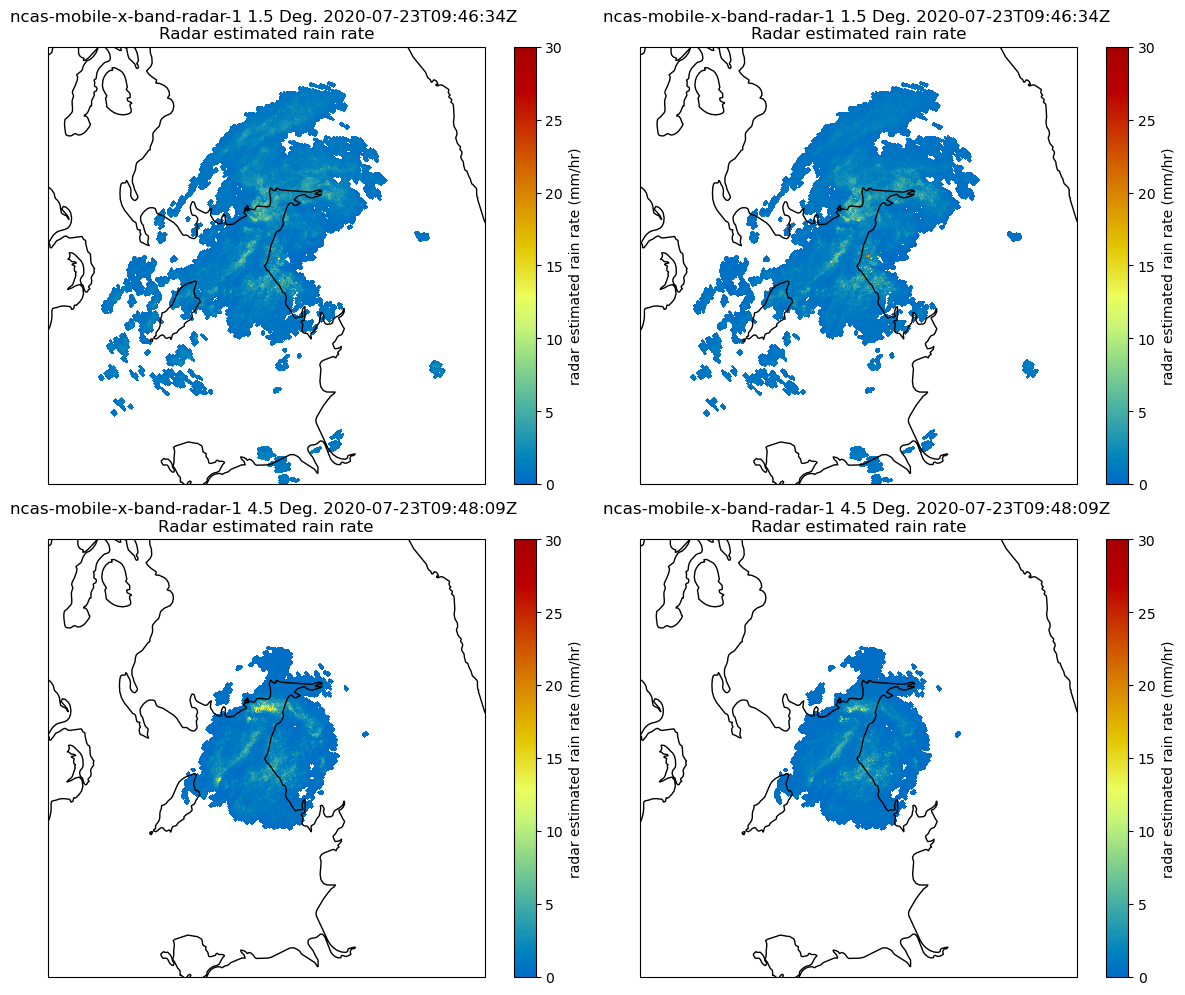

In [14]:
proj = raddisp.grid_projection

fig = plt.figure(figsize=(12,10))

ax1 = plt.subplot(221, projection=proj)
raddisp.plot_ppi_map("Rainfall_Z", 2,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax1)

ax1.coastlines(resolution='10m')

ax2 = plt.subplot(222, projection=proj)
raddisp.plot_ppi_map("Rainfall_hybrid_2", 2,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax2)

ax2.coastlines(resolution='10m')


ax3 = plt.subplot(223, projection=proj)
raddisp.plot_ppi_map("Rainfall_Z", 5,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax3)

ax3.coastlines(resolution='10m')

ax4 = plt.subplot(224, projection=proj)
raddisp.plot_ppi_map("Rainfall_hybrid_2", 5,
                 cmap=pycm.HomeyerRainbow,
                     gatefilter=gatefilter,
                     embellish=False,
                     vmin=0,vmax=30,
                 ax=ax4)

ax4.coastlines(resolution='10m')

plt.tight_layout()

While this is an overly simplified example of generating a multi-moment radar QPE which accounts for the melting layer it shows how Py-ART can be used to develop an increasingly complex processing chain. There are several alternative QPE retrievals within Py-ART that can also be explored. If you combine those with exploring the Z-PHI method of specific attenuation estimation (from the previous part) you can then consider whether R(A) based QPE would be more suitable for use in the future.

Now that we've quickly covered the development of a processing chain using Py-ART there is time for you to explore these techniques with the case study data. Feel free to expand beyond the functions used in these 4 exercises once you get comfortable with interogating the additional options.

Things to think about while developing the processing:
1. What does the case study show? Therefore what is the optimal final data product? (It may not always be QPE)
2. How agressive do the filters need to be? Do they need adapting to the final data product?
3. Is attenuation correction required?



##### Reference
Ryzhkov, Alexander V., and Dusan S. Zrnic. ‘Polarimetric Measurements of Precipitation’. In Radar Polarimetry for Weather Observations, edited by Alexander V. Ryzhkov and Dusan S. Zrnic, 373–433. Springer Atmospheric Sciences. Cham: Springer International Publishing, 2019. https://doi.org/10.1007/978-3-030-05093-1_10.
